In [102]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
# Patch to fix value too big error
import pandas.io.json

# monkeypatch using standard python json module
import json
pd.io.json._json.loads = lambda s, *a, **kw: json.loads(s)

## Creating a dataset of the top currencies

### Whattomine dataset

In [104]:
whattomine_data = pd.read_json('data/asic.json',orient="records")
whattomine_data = pd.json_normalize(whattomine_data['coins']).set_index(whattomine_data.index.str.lower())
whattomine_data['block_time'] = pd.to_numeric(whattomine_data['block_time'])
whattomine_data['nethash'] = pd.to_numeric(whattomine_data['nethash'])
whattomine_data.sort_values(by='algorithm')

,id,tag,algorithm,block_time,block_reward,block_reward24,last_block,difficulty,difficulty24,nethash,...,exchange_rate_curr,market_cap,estimated_rewards,estimated_rewards24,btc_revenue,btc_revenue24,profitability,profitability24,lagging,timestamp
bitcoindiamond,278,BCD,BCD,579.0000,125.000000,125.000000,607535,6.421233e+06,6.175700e+06,4.763210e+13,...,BTC,"$135,398,972.47",0.07245,0.07533,0.00000542,0.00000563,1,1,False,1582538192
nicehash-blake (14r),16,NICEHASH,Blake (14r),1.0000,1.000000,1.000000,0,1.000000e+00,1.000000e+00,1.640317e+13,...,BTC,$0.00,0.00016,0.00013,0.00016124,0.00013481,19,16,False,1582538289
decred,152,DCR,Blake (14r),281.0000,9.420478,9.420478,426396,2.670300e+10,2.482635e+10,4.081442e+17,...,BTC,"$231,372,675.68",0.20579,0.22135,0.00045478,0.00048915,53,57,False,1582538218
karbo,176,KRB,CryptoNight,248.0000,6.626516,6.630758,458958,8.205817e+09,8.422403e+09,3.308797e+07,...,BTC,"$481,210.55",24.84735,24.23059,0.00014908,0.00014538,17,17,False,1582538060
dero,291,DERO,CryptoNight,11.7833,0.915364,0.917639,4465113,6.445025e+09,6.370287e+09,5.469627e+08,...,BTC,"$7,896,007.97",4.41468,4.47755,0.00038013,0.00038554,44,45,False,1582538224
bytecoin,103,BCN,CryptoNight,198.0000,374.434699,374.750719,1993764,8.129765e+09,1.073821e+10,4.105942e+07,...,BTC,"$89,329,932.86",1420.11384,1078.3341,0.00007101,0.00005392,8,6,False,1582538200
zcash,166,ZEC,Equihash,75.0000,5.000000,5.000000,739015,6.030782e+07,5.246656e+07,6.587222e+09,...,BTC,"$557,801,012.57",0.18362,0.21106,0.00115813,0.00133121,134,154,False,1582538192
komodo,174,KMD,Equihash,62.0000,3.000000,3.000000,1763233,2.007803e+08,2.272936e+08,5.181428e+07,...,BTC,"$87,748,527.76",16.87549,14.91403,0.0012876,0.00113794,149,131,False,1582538299
nicehash-equihash,19,NICEHASH,Equihash,1.0000,1.000000,1.000000,0,1.000000e+00,1.000000e+00,1.923703e+08,...,BTC,$0.00,0.00144,0.00137,0.00143644,0.00137181,166,158,False,1582538289
horizen,185,ZEN,Equihash,150.0000,7.500000,7.500000,679180,1.404942e+07,1.504358e+07,7.672858e+08,...,BTC,"$98,120,904.01",1.18203,1.10393,0.00140756,0.00131456,163,152,False,1582537938


In [98]:
whattomine_data.loc['litecoin']

id                                     4
tag                                  LTC
algorithm                         Scrypt
block_time                           140
block_reward                        12.5
block_reward24                      12.5
last_block                       1794842
difficulty                   5.97583e+06
difficulty24                 5.98135e+06
nethash                      1.83329e+14
exchange_rate                  0.0077846
exchange_rate24               0.00792389
exchange_rate_vol                1827.07
exchange_rate_curr                   BTC
market_cap             $4,847,238,836.32
estimated_rewards                0.05218
estimated_rewards24              0.05213
btc_revenue                   0.00040618
btc_revenue24                 0.00040581
profitability                         47
profitability24                       47
lagging                            False
timestamp                     1582538293
Name: litecoin, dtype: object

In [105]:
# All relative to bitcoin, put in dollars
whattomine_data['exchange_rate'] *= whattomine_data.loc['bitcoin','exchange_rate']
whattomine_data.loc['bitcoin','exchange_rate'] = np.sqrt(whattomine_data.loc['bitcoin','exchange_rate'])
whattomine_data['exchange_rate']

actinium                   0.024654
axe                        0.483371
bitcoin                 9706.250000
bitcoincashabc           385.464306
bitcoindiamond             0.726028
bitcoinsv                285.189037
bytecoin                   0.000485
dgb-qubit                  0.006794
dgb-sha                    0.006794
dgb-scrypt                 0.006794
dgb-skein                  0.006794
dash                     103.721376
decred                    21.449551
dero                       0.835768
dogecoin                   0.002604
einsteinium                0.046105
euno                       0.006309
florin                     0.038631
gamecredits                0.047075
groestlcoin                0.208684
horizen                   11.558203
hush                       0.067468
imagecoin                  0.139285
karbo                      0.058238
komodo                     0.740587
lbry                       0.016209
litecoin                  75.559274
litecoincash               0

In [7]:
whattomine_data['algorithm'].value_counts()

Scrypt         10
SHA-256         8
Equihash        6
X11             5
Lyra2REv2       4
CryptoNight     3
Qubit           2
Myr-Groestl     2
Blake (14r)     2
Keccak          2
LBRY            2
Lyra2z          2
Quark           1
BCD             1
Sia             1
X11Gost         1
Skein           1
Groestl         1
Name: algorithm, dtype: int64

In [109]:
# Clean up columns for ease of use
data_clean_1 = whattomine_data[['tag', 'algorithm', 'difficulty', 'block_time', 'block_reward', 'exchange_rate']].copy()
data_clean_1

,tag,algorithm,difficulty,block_time,block_reward,exchange_rate
actinium,ACM,Lyra2z,8.495470e+03,148.0000,50.000000,0.024654
axe,AXE,X11,1.642766e+06,155.0000,2.193750,0.483371
bitcoin,BTC,SHA-256,1.554675e+13,599.0000,12.619200,9706.250000
bitcoincashabc,BCH,SHA-256,5.721857e+11,601.0000,12.500000,385.464306
bitcoindiamond,BCD,BCD,6.421233e+06,579.0000,125.000000,0.726028
bitcoinsv,BSV,SHA-256,4.315897e+11,578.0000,12.500000,285.189037
bytecoin,BCN,CryptoNight,8.129765e+09,198.0000,374.434699,0.000485
dgb-qubit,DGB,Qubit,3.794882e+06,75.0000,608.481631,0.006794
dgb-sha,DGB,SHA-256,4.214447e+08,75.0000,608.481631,0.006794
dgb-scrypt,DGB,Scrypt,2.661442e+04,75.0000,608.481631,0.006794


### Coinwarz api

In [24]:
profitability = pd.read_json('data/profitability.json')
profitability = pd.json_normalize(profitability['Data'])
profitability['CoinName'] = profitability['CoinName'].str.lower()
profitability.iloc[2,0] = 'ethereumclassic'
profitability

,CoinName,CoinTag,Algorithm,Difficulty,BlockReward,BlockCount,ProfitRatio,AvgProfitRatio,Exchange,ExchangeRate,ExchangeVolume,IsBlockExplorerOnline,IsExchangeOnline,Message,BlockTimeInSeconds,HealthStatus
0,verge,XVG,Scrypt,5.664491e+03,730.000000,3872165,672.032547,222.468834,Bittrex,4.200000e-07,5.656103e+06,True,True,,30,Healthy
1,cannabiscoin,CANN,X11,1.878325e+04,70.000000,4242347,352.056440,479.340798,YoBit,2.800000e-07,8.083233e+03,True,True,,42,Healthy
2,ethereumclassic,ETC,EtHash,1.543936e+14,4.000000,9902870,308.307749,258.195031,Bittrex,9.296700e-04,1.188019e+04,True,True,,15,Healthy
3,ethereum,ETH,EtHash,2.244509e+15,2.000000,9591682,287.713705,256.673880,Bittrex,2.558124e-02,5.202664e+03,True,True,,15,Healthy
4,gamecredits,GAME,Scrypt,2.822142e+03,12.500000,2666684,148.764015,111.186129,Bittrex,4.990000e-06,8.902183e+04,True,True,,90,Healthy
5,zcash,ZEC,Equihash,5.160684e+07,5.000000,747160,148.102948,143.695540,hitbtc,5.771840e-03,4.062293e+04,True,True,,75,Healthy
6,peercoin,PPC,SHA-256,1.561012e+09,55.172653,484148,116.453891,65.657217,Bittrex,2.409000e-05,2.262497e+04,True,True,,600,Healthy
7,bitcoin,BTC,SHA-256,1.548691e+13,12.500000,619838,100.000000,100.000000,CoinWarz,8.761835e+03,1.052788e+04,True,True,,600,Healthy
8,bitcoincash,BCH,SHA-256,5.728909e+11,12.500000,624693,98.202165,90.294355,Bittrex,3.677005e-02,3.383994e+02,True,True,,600,Healthy
9,digibyte,DGB,Scrypt,2.286140e+04,665.639774,10409124,92.105616,-184.367269,Bittrex,6.400000e-07,1.685394e+07,True,True,,15,Healthy


In [83]:
data_clean_2 = profitability[['CoinName','CoinTag','Algorithm','Difficulty','BlockTimeInSeconds', 'BlockReward', 'ExchangeRate']].set_index('CoinName')
data_clean_2

,CoinTag,Algorithm,Difficulty,BlockTimeInSeconds,BlockReward,ExchangeRate
CoinName,,,,,,
verge,XVG,Scrypt,5.664491e+03,30,730.000000,4.200000e-07
cannabiscoin,CANN,X11,1.878325e+04,42,70.000000,2.800000e-07
ethereumclassic,ETC,EtHash,1.543936e+14,15,4.000000,9.296700e-04
ethereum,ETH,EtHash,2.244509e+15,15,2.000000,2.558124e-02
gamecredits,GAME,Scrypt,2.822142e+03,90,12.500000,4.990000e-06
zcash,ZEC,Equihash,5.160684e+07,75,5.000000,5.771840e-03
peercoin,PPC,SHA-256,1.561012e+09,600,55.172653,2.409000e-05
bitcoin,BTC,SHA-256,1.548691e+13,600,12.500000,8.761835e+03
bitcoincash,BCH,SHA-256,5.728909e+11,600,12.500000,3.677005e-02


In [114]:
data_clean_2 = data_clean_2.rename(columns={'CoinTag':'tag','Algorithm':'algorithm','Difficulty':'difficulty', 
                                            'BlockTimeInSeconds':'block_time', 'BlockReward': 'block_reward','ExchangeRate':'exchange_rate'})
# All relative to bitcoin, put in dollars
data_clean_2['exchange_rate'] *= data_clean_2.loc['bitcoin','exchange_rate']
data_clean_2.loc['bitcoin','exchange_rate'] = np.sqrt(data_clean_2.loc['bitcoin','exchange_rate'])
data_clean_2

,tag,algorithm,difficulty,block_time,block_reward,exchange_rate
CoinName,,,,,,
verge,XVG,Scrypt,5.664491e+03,30,730.000000,0.003680
cannabiscoin,CANN,X11,1.878325e+04,42,70.000000,0.002453
ethereumclassic,ETC,EtHash,1.543936e+14,15,4.000000,8.145615
ethereum,ETH,EtHash,2.244509e+15,15,2.000000,224.138591
gamecredits,GAME,Scrypt,2.822142e+03,90,12.500000,0.043722
zcash,ZEC,Equihash,5.160684e+07,75,5.000000,50.571907
peercoin,PPC,SHA-256,1.561012e+09,600,55.172653,0.211073
bitcoin,BTC,SHA-256,1.548691e+13,600,12.500000,8761.834500
bitcoincash,BCH,SHA-256,5.728909e+11,600,12.500000,322.173093


Let's combine it with the list of top 100 cryptocurrencies and check how many we're missing

### Top100 cryptocurrencies

In [28]:
top100 = pd.read_csv('data/top100_crypto.csv',encoding='utf-8')
top100

,Name,Market Cap ($),Price,Volume (24h),Circulating Supply
0,Bitcoin,1.582063e+11,8669.950000,36604114509,"18,247,675 BTC"
1,Ethereum,2.440093e+10,221.980000,17556366958,"109,925,923 ETH"
2,XRP,1.020496e+10,0.233099,2089256294,"43,779,512,655 XRP *"
3,Bitcoin Cash,5.865094e+09,320.350000,4251315222,"18,308,363 BCH"
4,Tether,4.641706e+09,0.999857,45768057216,"4,642,367,414 USDT *"
...,...,...,...,...,...
95,RIF Token,4.403880e+07,0.077334,7695266,"569,460,014 RIF *"
96,WAX,4.356755e+07,0.041348,1251586,"1,053,674,051 WAXP *"
97,Power Ledger,4.293771e+07,0.100149,16331006,"428,738,728 POWR *"
98,Decentraland,4.209455e+07,0.040085,13970730,"1,050,141,509 MANA *"


Currencies with a * in 'Circulating Supply' are non mineable, let us make an extra column of that

In [29]:
# Split circulating supply into numerical value, code, and mineable
top100['code'] = top100['Circulating Supply'].apply(lambda x: x.split()[1])
top100['mineable'] = ~top100['Circulating Supply'].str.contains('\*')
top100['Circulating Supply'] = top100['Circulating Supply'].apply(lambda x: int(x.split()[0].replace(',','')))
top100

,Name,Market Cap ($),Price,Volume (24h),Circulating Supply,code,mineable
0,Bitcoin,1.582063e+11,8669.950000,36604114509,18247675,BTC,True
1,Ethereum,2.440093e+10,221.980000,17556366958,109925923,ETH,True
2,XRP,1.020496e+10,0.233099,2089256294,43779512655,XRP,False
3,Bitcoin Cash,5.865094e+09,320.350000,4251315222,18308363,BCH,True
4,Tether,4.641706e+09,0.999857,45768057216,4642367414,USDT,False
...,...,...,...,...,...,...,...
95,RIF Token,4.403880e+07,0.077334,7695266,569460014,RIF,False
96,WAX,4.356755e+07,0.041348,1251586,1053674051,WAXP,False
97,Power Ledger,4.293771e+07,0.100149,16331006,428738728,POWR,False
98,Decentraland,4.209455e+07,0.040085,13970730,1050141509,MANA,False


#### Mineable

Let us start by looking only at the mineable currencies

In [30]:
mineable = top100[top100['mineable'] == True].copy()
mineable['Name'] = mineable['Name'].str.replace(' ','').str.lower()
mineable

,Name,Market Cap ($),Price,Volume (24h),Circulating Supply,code,mineable
0,bitcoin,1.582063e+11,8669.950000,36604114509,18247675,BTC,True
1,ethereum,2.440093e+10,221.980000,17556366958,109925923,ETH,True
3,bitcoincash,5.865094e+09,320.350000,4251315222,18308363,BCH,True
5,bitcoinsv,4.250278e+09,232.180000,2250321444,18305602,BSV,True
6,litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,True
11,cardano,1.226269e+09,0.047297,102267054,25927070538,ADA,True
13,monero,1.159233e+09,66.370000,101835102,17466147,XMR,True
14,tron,1.123979e+09,0.016856,1570324125,66682072191,TRX,True
17,ethereumclassic,9.465897e+08,8.140000,1614433225,116313299,ETC,True
18,dash,8.145112e+08,87.020000,747414446,9359544,DASH,True


In [31]:
mineable.shape

(31, 7)

In [32]:
mineable['in_whattomine_data'] = mineable['Name'].apply(lambda x: x in whattomine_data.index)
mineable['in_coinwarz_data'] = mineable['Name'].apply(lambda x: x in profitability.CoinName.values)

#### Missing data

In [33]:
missing_data = mineable[~mineable['in_whattomine_data'] & ~mineable['in_coinwarz_data']]
missing_data

,Name,Market Cap ($),Price,Volume (24h),Circulating Supply,code,mineable,in_whattomine_data,in_coinwarz_data
11,cardano,1.226269e+09,0.047297,102267054,25927070538,ADA,True,False,False
14,tron,1.123979e+09,0.016856,1570324125,66682072191,TRX,True,False,False
36,algorand,1.930636e+08,0.328960,93702462,586890345,ALGO,True,False,False
38,bitcoingold,1.700709e+08,9.710000,39606584,17513924,BTG,True,False,False
58,siacoin,9.645836e+07,0.002307,1228490,41817047634,SC,True,False,False
67,bytom,7.823782e+07,0.078043,11905912,1002499275,BTM,True,False,False
73,hypercash,6.840370e+07,1.540000,24719969,44528736,HC,True,False,False
79,aion,6.181198e+07,0.154231,7094352,400776284,AION,True,False,False
80,zilliqa,5.992715e+07,0.006027,78526799,9942807276,ZIL,True,False,False
89,aeternity,5.084859e+07,0.167894,9674993,302860498,AE,True,False,False


### Combining the datasets

difficulty/nethash = block time

In [115]:
necessary_data = ['algorithm', 'difficulty', 'block_time', 'block_reward', 'exchange_rate']

In [116]:
def fill_data(coin, data):
    if coin['in_whattomine_data']:
        return data_clean_1.loc[coin['Name'],data]
    elif coin['in_coinwarz_data']:
        return data_clean_2.loc[coin['Name'],data]
    else:
        return

In [117]:
for data in necessary_data:
    mineable[data] = mineable.apply(lambda x: fill_data(x,data), axis=1)

In [118]:
mining_data = mineable.drop(columns=['mineable', 'in_whattomine_data', 'in_coinwarz_data'])
mining_data['position'] = mining_data.index
mining_data = mining_data.set_index('Name')
mining_data

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position
Name,,,,,,,,,,,
bitcoin,1.582063e+11,8669.950000,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,12.619200,9706.250000,0
ethereum,2.440093e+10,221.980000,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.000000,224.138591,1
bitcoincash,5.865094e+09,320.350000,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,12.500000,322.173093,3
bitcoinsv,4.250278e+09,232.180000,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,12.500000,285.189037,5
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6
cardano,1.226269e+09,0.047297,102267054,25927070538,ADA,None,NaN,NaN,NaN,NaN,11
monero,1.159233e+09,66.370000,101835102,17466147,XMR,RandomX,1.576720e+11,120.0,2.150000,66.854550,13
tron,1.123979e+09,0.016856,1570324125,66682072191,TRX,None,NaN,NaN,NaN,NaN,14
ethereumclassic,9.465897e+08,8.140000,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.000000,8.145615,17


In [119]:
# Manually fill or remove missing data
def fill_missing(mining_data):
    mining_data.loc['cardano','algorithm'] = 'PoS' 
    mining_data.loc['tron','algorithm'] = 'DPoS'# Delegated proof-of-stake
    mining_data.loc['algorand','algorithm'] = 'PoS' 
    
    # bitcoin gold
    mining_data.loc['bitcoingold','algorithm'] = 'Equihash'
    mining_data.loc['bitcoingold','difficulty'] = 176590
    mining_data.loc['bitcoingold','block_time'] = 600

    mining_data.loc['siacoin', 'algorithm'] = 'PoSpace'
        
    return mining_data

    

In [120]:
mining_data = fill_missing(mining_data)
mining_data

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position
Name,,,,,,,,,,,
bitcoin,1.582063e+11,8669.950000,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,12.619200,9706.250000,0
ethereum,2.440093e+10,221.980000,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.000000,224.138591,1
bitcoincash,5.865094e+09,320.350000,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,12.500000,322.173093,3
bitcoinsv,4.250278e+09,232.180000,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,12.500000,285.189037,5
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6
cardano,1.226269e+09,0.047297,102267054,25927070538,ADA,PoS,NaN,NaN,NaN,NaN,11
monero,1.159233e+09,66.370000,101835102,17466147,XMR,RandomX,1.576720e+11,120.0,2.150000,66.854550,13
tron,1.123979e+09,0.016856,1570324125,66682072191,TRX,DPoS,NaN,NaN,NaN,NaN,14
ethereumclassic,9.465897e+08,8.140000,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.000000,8.145615,17


In [121]:
print(mining_data['algorithm'].value_counts())
mining_data.sort_values(by='algorithm')

Scrypt         4
Equihash       4
SHA-256        3
EtHash         2
PoS            2
PoSpace        1
Blake (14r)    1
Lyra2REv2      1
DPoS           1
CryptoNight    1
BCD            1
X11            1
X16Rv2         1
RandomX        1
Name: algorithm, dtype: int64


,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position
Name,,,,,,,,,,,
bitcoindiamond,1.221663e+08,0.655072,11294459,186492898,BCD,BCD,6.421233e+06,579.0,125.000000,0.726028,48
decred,1.891563e+08,17.540000,102700127,10786831,DCR,Blake (14r),2.670300e+10,281.0,9.420478,21.449551,37
bytecoin,9.270225e+07,0.000504,19536,184066828814,BCN,CryptoNight,8.129765e+09,198.0,374.434699,0.000485,59
tron,1.123979e+09,0.016856,1570324125,66682072191,TRX,DPoS,NaN,NaN,NaN,NaN,14
bitcoingold,1.700709e+08,9.710000,39606584,17513924,BTG,Equihash,1.765900e+05,600.0,NaN,NaN,38
komodo,7.592247e+07,0.640276,2536293,118577670,KMD,Equihash,2.007803e+08,62.0,3.000000,0.740587,69
zcash,4.609111e+08,50.030000,311995941,9212506,ZEC,Equihash,6.030782e+07,75.0,5.000000,61.218484,25
horizen,8.559170e+07,10.020000,1543230,8539588,ZEN,Equihash,1.404942e+07,150.0,7.500000,11.558203,63
ethereumclassic,9.465897e+08,8.140000,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.000000,8.145615,17


## Energy of different consensus algorithms

### SHA-256 Proof-of-Work

In [69]:
sha_256 = mining_data[mining_data['algorithm'] == "SHA-256"].copy()
sha_256

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position
Name,,,,,,,,,
bitcoin,1.582063e+11,8669.95,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,0
bitcoincash,5.865094e+09,320.35,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,3
bitcoinsv,4.250278e+09,232.18,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,5


In [71]:
# All correct! 
sha_256['total_hash'] = sha_256['difficulty']*2**48/(65535) # or 2^32 
sha_256['nethash'] = sha_256['total_hash']/sha_256['block_time']
sha_256

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position,total_hash,nethash
Name,,,,,,,,,,,
bitcoin,1.582063e+11,8669.95,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,0,6.677378e+22,1.114754e+20
bitcoincash,5.865094e+09,320.35,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,3,2.460585e+21,4.100975e+18
bitcoinsv,4.250278e+09,232.18,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,5,1.853692e+21,3.207080e+18


### Equihash

In [76]:
equihash = mining_data[mining_data['algorithm'] == "Equihash"].copy()
equihash['(n,k)'] = [(200,9),(144,5),(0,0),(200,9)]
equihash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position,"(n,k)"
Name,,,,,,,,,,
zcash,460911098.0,50.030000,311995941,9212506,ZEC,Equihash,6.030782e+07,75.0,25,"(200, 9)"
bitcoingold,170070863.0,9.710000,39606584,17513924,BTG,Equihash,1.765900e+05,600.0,38,"(144, 5)"
horizen,85591701.0,10.020000,1543230,8539588,ZEN,Equihash,1.404942e+07,150.0,63,"(0, 0)"
komodo,75922471.0,0.640276,2536293,118577670,KMD,Equihash,2.007803e+08,62.0,69,"(200, 9)"


In [129]:
equihash['alg_runs'] = 2**13*equihash['difficulty']/2 # Starting difficulty of Zcash, times the relative difficulty, divided by amount of solution
equihash['hashrate'] = equihash['alg_runs']/equihash['block_time']
equihash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,position,"(n,k)",alg_runs,hashrate
Name,,,,,,,,,,,,
zcash,460911098.0,50.030000,311995941,9212506,ZEC,Equihash,6.030782e+07,75.0,25,"(200, 9)",2.470208e+11,3.293611e+09
bitcoingold,170070863.0,9.710000,39606584,17513924,BTG,Equihash,1.765900e+05,600.0,38,"(144, 5)",7.233126e+08,1.205521e+06
horizen,85591701.0,10.020000,1543230,8539588,ZEN,Equihash,1.404942e+07,150.0,63,"(0, 0)",5.754643e+10,3.836429e+08
komodo,75922471.0,0.640276,2536293,118577670,KMD,Equihash,2.007803e+08,62.0,69,"(200, 9)",8.223963e+11,1.326446e+10


### Scrypt

In [130]:
scrypt = mining_data[mining_data['algorithm'] == "Scrypt"].copy()
scrypt

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec
Name,,,,,,,,,,,,
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6,6.746364
dogecoin,2.820381e+08,0.002283,166256231,123544326274,DOGE,Scrypt,2.453764e+06,62.0,10000.000000,0.002604,32,0.420077
digibyte,7.191128e+07,0.005583,824878,12880917393,DGB,Scrypt,2.286140e+04,15.0,665.639774,0.005608,71,0.248842
verge,5.942903e+07,0.003670,691527,16193811143,XVG,Scrypt,5.664491e+03,30.0,730.000000,0.003680,81,0.089546


In [136]:
# TODO: all litecoin! 
scrypt.loc['litecoin','alg_runs'] = 2**32*scrypt.loc['litecoin','difficulty']/scrypt.loc['litecoin','block_time'] # https://litecoin.info/index.php/Difficulty
scrypt

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec,alg_runs
Name,,,,,,,,,,,,,
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6,6.746364,1.833287e+14
dogecoin,2.820381e+08,0.002283,166256231,123544326274,DOGE,Scrypt,2.453764e+06,62.0,10000.000000,0.002604,32,0.420077,NaN
digibyte,7.191128e+07,0.005583,824878,12880917393,DGB,Scrypt,2.286140e+04,15.0,665.639774,0.005608,71,0.248842,NaN
verge,5.942903e+07,0.003670,691527,16193811143,XVG,Scrypt,5.664491e+03,30.0,730.000000,0.003680,81,0.089546,NaN


### EtHash

In [131]:
ethash = mining_data[mining_data['algorithm'] == "EtHash"].copy()
ethash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec
Name,,,,,,,,,,,,
ethereum,2.440093e+10,221.98,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.0,224.138591,1,29.885145
ethereumclassic,9.465897e+08,8.14,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.0,8.145615,17,2.172164


In [134]:
ethash['hashrate'] = ethash['difficulty']/ethash['block_time']
ethash

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec,hashrate
Name,,,,,,,,,,,,,
ethereum,2.440093e+10,221.98,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.0,224.138591,1,29.885145,1.496340e+14
ethereumclassic,9.465897e+08,8.14,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.0,8.145615,17,2.172164,1.029291e+13


+- same as other online clients

## Lower bound

In this approach, we look at the number of hashes the miners are actually computing, which we know by observing the difficulty of each block. If we then assume that all miners are using the most efficient hardware, we can derive a lower bound on electricity consumption.

As of writing, the most efficient hardware is the 'Antminer S9', which calculates 14TH/s
https://www.buybitcoinworldwide.com/mining/hardware/

In [41]:
max_hash_rate = 14*10**12 # Hashes per second
joules_per_hash = 0.1/(10**9) # Joules per hash
energy_cons = max_hash_rate*joules_per_hash # In Watt

In [46]:
def lower_bound(coin):
    """
    Return a lower bound on the amount of energy (in W) needed for a cryptocurrency using the SHA-256 algorithm
    """
    # Hashrate per second needed
    hashrate = coin['nethash']
    # Amount of ASIC's needed to generate this hashrate
    num_hardware = hashrate/max_hash_rate
    total_energy = num_hardware*energy_cons
    return total_energy

In [49]:
energy = lower_bound(sha_256.loc['Bitcoin'])

In [50]:
# Convert W to Wh
energy_Wh = energy*3600 

In [52]:
print(f"The Bitcoin cryptocurrency consumes, as a minimum {energy_Wh/10**12} TWh of energy")

The Bitcoin cryptocurrency consumes, as a minimum 40.13054301165688 TWh of energy


In [53]:
sha_256.apply(lambda x: lower_bound(x)*3600/10**12, axis=1)

Bitcoin           40.130543
BitcoinCashABC     1.472058
BitcoinSV          1.154531
DGB-SHA            0.008688
LitecoinCash       0.001109
Myriad-SHA         3.265881
Nicehash-SHA       0.145141
Peercoin           0.000997
dtype: float64

## Reward to energy estimation

In [122]:
mining_data['reward_per_sec'] = mining_data['block_reward']*mining_data['exchange_rate']/mining_data['block_time']
mining_data

,Market Cap ($),Price,Volume (24h),Circulating Supply,code,algorithm,difficulty,block_time,block_reward,exchange_rate,position,reward_per_sec
Name,,,,,,,,,,,,
bitcoin,1.582063e+11,8669.950000,36604114509,18247675,BTC,SHA-256,1.554675e+13,599.0,12.619200,9706.250000,0,204.482654
ethereum,2.440093e+10,221.980000,17556366958,109925923,ETH,EtHash,2.244509e+15,15.0,2.000000,224.138591,1,29.885145
bitcoincash,5.865094e+09,320.350000,4251315222,18308363,BCH,SHA-256,5.728909e+11,600.0,12.500000,322.173093,3,6.711939
bitcoinsv,4.250278e+09,232.180000,2250321444,18305602,BSV,SHA-256,4.315897e+11,578.0,12.500000,285.189037,5,6.167583
litecoin,3.801726e+09,59.210000,4433870551,64202387,LTC,Scrypt,5.975834e+06,140.0,12.500000,75.559274,6,6.746364
cardano,1.226269e+09,0.047297,102267054,25927070538,ADA,PoS,NaN,NaN,NaN,NaN,11,NaN
monero,1.159233e+09,66.370000,101835102,17466147,XMR,RandomX,1.576720e+11,120.0,2.150000,66.854550,13,1.197811
tron,1.123979e+09,0.016856,1570324125,66682072191,TRX,DPoS,NaN,NaN,NaN,NaN,14,NaN
ethereumclassic,9.465897e+08,8.140000,1614433225,116313299,ETC,EtHash,1.543936e+14,15.0,4.000000,8.145615,17,2.172164


In [124]:
sum_of_rewards = np.sum(mining_data['reward_per_sec'])
sum_of_rewards

267.38749988175215

In [125]:
average_price = 0.14 # $ per kWh

In [126]:
sum_of_rewards/average_price

1909.9107134410865

## Bitcoin Energy Consumption Index

In [22]:
BECI = pd.read_csv('data/BECI_TWh.csv')
BECI['Date'] = pd.to_datetime(BECI['Date'])

In [28]:
BECI = BECI.set_index('Date')

In [30]:
BECI_avg = BECI.groupby(pd.Grouper(freq='M')).mean()

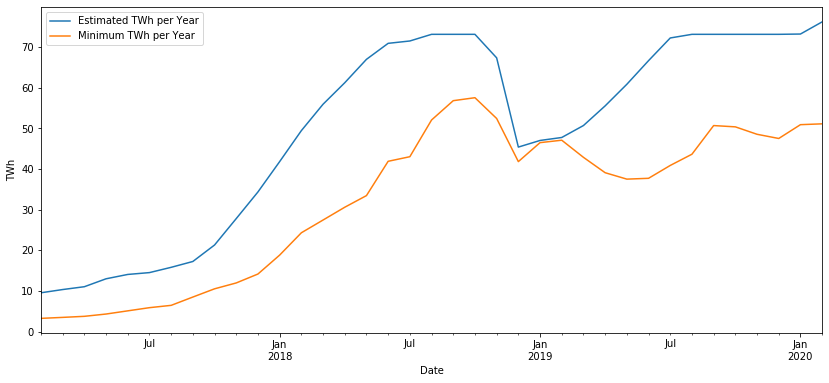

In [49]:
BECI_avg.plot(figsize=(14,6))
plt.ylabel('TWh')
plt.show()